### Initialize the environment

In [1]:
import theano
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
src_dir='../src' # source directory
run_dir_prefix='../MDBN_run/AML_Batch_' # directory with the results of previous runs
data_dir='../data' # directory with the data files

In [3]:
import sys
sys.path.insert(0, src_dir)
import rbm
import MDBN
import main

### Load the experiment results

In [4]:
run=0
uuid='eb6856a251bb8680da6593de98db7b5a'
timestamp='20170220T205506' # specify the date and time of the run in the format YYYYmmddTHHMMSS
run_dir=run_dir_prefix+timestamp
runfile='Exp_%s_run_%s.npz' % (uuid, run) # location of the experiment results
mdbn = MDBN.MDBN()
config, dbn_dict = mdbn.load_network(runfile, run_dir)

In [5]:
config

{u'dbns': {u'GE': {u'batchSize': 1,
   u'datafile': u'AML/AML_gene_expression_table2.csv.gz',
   u'epochs': [20, 800],
   'inputNodes': 19937,
   u'k': 1,
   u'lambdas': [0.0, 1.0],
   u'layersNodes': [400, 40],
   u'lr': [0.0005, 0.1],
   u'persistent': False},
  u'ME': {u'batchSize': 1,
   u'datafile': u'AML/AML_miRNA_Seq_table2.csv.gz',
   u'epochs': [20],
   'inputNodes': 559,
   u'k': 10,
   u'lambdas': [0.0, 0.1],
   u'layersNodes': [40],
   u'lr': [0.005],
   u'persistent': False},
  u'SM': {u'batchSize': 1,
   u'datafile': u'AML/AML_somatic_mutations_table2.csv.gz',
   u'epochs': [20, 800],
   'inputNodes': 1686,
   u'k': 1,
   u'lambdas': [0.0, 0.1],
   u'layersNodes': [200, 20],
   u'lr': [0.01, 0.1],
   u'persistent': False}},
 u'name': u'aml_config_20_1_05.json',
 u'p': 0.5,
 u'pathways': [u'ME', u'GE', u'SM'],
 u'runs': 4,
 u'seed': 1234,
 u'top': {u'batchSize': 1,
  u'epochs': [800, 800],
  'inputNodes': 100,
  u'k': 1,
  u'layersNodes': [24, 3],
  u'lr': [0.1, 0.1],
  u'

### Load the data

In [6]:
datafiles = main.prepare_TCGA_datafiles("AML",config,data_dir)

In [7]:
import utils
real_set, _ = utils.load_n_preprocess_data(datafiles['ME'],datadir=data_dir)
real_set.get_value().shape

(170, 559)

#### Compute the joint layer components

In [8]:
dbn_output_list=[]
for key in config['pathways']:
    dbn_output, _ = dbn_dict[key].MLP_output_from_datafile(datafiles[key], datadir=data_dir)
    dbn_output_list.append(dbn_output)

In [9]:
dbn_output = dbn_dict['ME'].get_output(theano.shared(np.zeros(real_set.get_value().shape,
                                                                        dtype=theano.config.floatX),borrow=True))
#dbn_output = np.zeros((real_set.get_value().shape[0],40),dtype=theano.config.floatX)

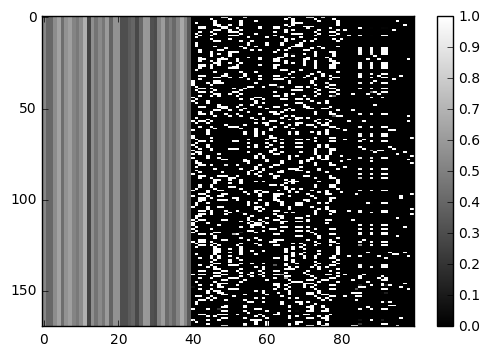

In [10]:
joint_layer = np.concatenate([dbn_output,dbn_output_list[1],dbn_output_list[2]],axis=1)
plt.imshow(joint_layer, interpolation='none', cmap='gray')
plt.axis('tight')
plt.colorbar()

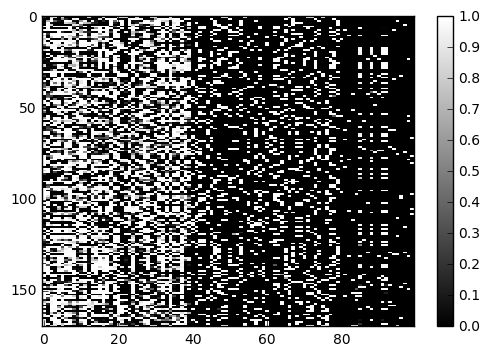

In [11]:
real_joint_layer = np.concatenate(dbn_output_list,axis=1)
plt.imshow(real_joint_layer, interpolation='none', cmap='gray')
plt.axis('tight')
plt.colorbar()

In [12]:
top_output = dbn_dict['top'].get_output(joint_layer)

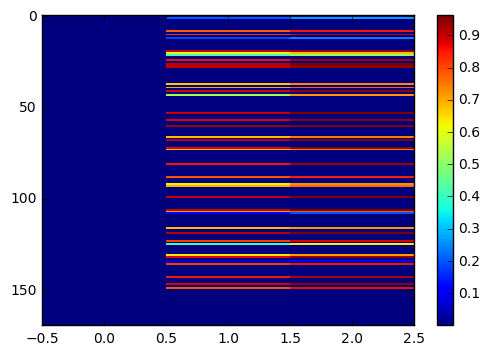

In [13]:
plt.imshow(top_output, interpolation='none')
plt.axis('tight')
plt.colorbar()

### Gibbs sampling of the top layer and prop down w/ ancestral sampling

We iterate the reconstruction 10 times

In [14]:
reload(rbm)

<module 'rbm' from '../src/rbm.pyc'>

In [15]:
top_dbn_rbm0 = dbn_dict['top'].rbm_layers[0]
top_dbn_rbm1 = dbn_dict['top'].rbm_layers[1]

In [16]:
h1 = theano.tensor.matrix('h1')
rec_joint_layer = top_dbn_rbm0.sample_v_given_h(h1)
rec_joint_fn = theano.function([h1], rec_joint_layer)

In [36]:
for i in range(10):
    top_output = dbn_dict['top'].get_output(joint_layer)
    sampled_hidden_layer = top_dbn_rbm1.reverse_sampling(1,theano.shared(top_output,borrow=True),20)
    sampled_joint_layer = rec_joint_fn(sampled_hidden_layer[0])
    joint_layer = np.concatenate([sampled_joint_layer[2][:,:40],joint_layer[:,40:100]],axis=1)

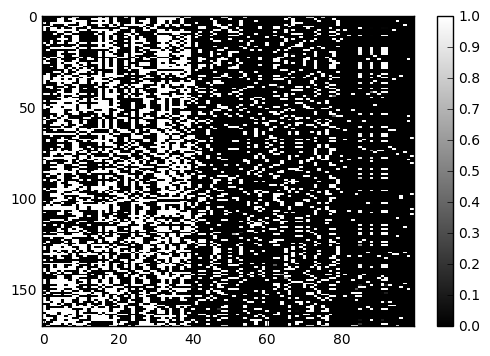

In [37]:
plt.imshow(joint_layer, interpolation='none', cmap='gray')
plt.axis('tight')
plt.colorbar()

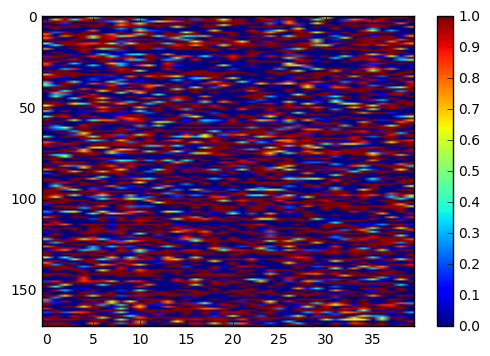

In [38]:
plt.imshow(np.sqrt(np.square(real_joint_layer[:,:40]-joint_layer[:,:40])))
plt.axis('tight')
plt.colorbar()

### Propagate down on the unimodal DBN

In [39]:
me_rbm = dbn_dict['ME'].rbm_layers[0]

In [40]:
sampled_vis_layer = me_rbm.reverse_sampling(1,theano.shared(joint_layer[:,:40],borrow=True))

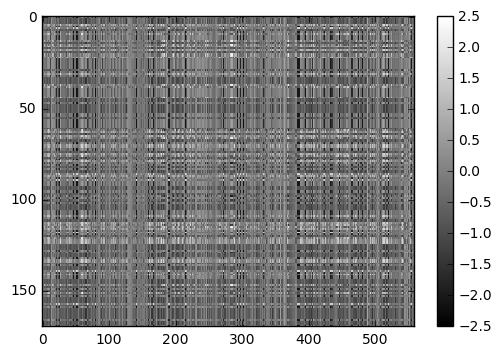

In [41]:
plt.imshow(sampled_vis_layer[0],interpolation='none',cmap='gray',clim=(-2.5,2.5))
plt.axis('tight')
plt.colorbar()

### Compare reconstructed and actual data

([array([   0.,    0.,    0.,   24.,  143.,    3.,    0.,    0.,    0.,    0.]),
  array([   0.,    0.,    0.,    0.,  159.,   11.,    0.,    0.,    0.,    0.]),
  array([  0.,   0.,   0.,  72.,  79.,  19.,   0.,   0.,   0.,   0.]),
  array([  0.,   0.,   5.,  64.,  60.,  11.,  21.,   9.,   0.,   0.]),
  array([  0.,   0.,   0.,  67.,  66.,  37.,   0.,   0.,   0.,   0.]),
  array([ 58.,   0.,   2.,  80.,  12.,  11.,   1.,   0.,   6.,   0.]),
  array([  0.,   0.,   0.,  77.,  90.,   3.,   0.,   0.,   0.,   0.]),
  array([  0.,   0.,  64.,   5.,   7.,  67.,  22.,   5.,   0.,   0.]),
  array([   0.,    0.,    0.,    0.,  152.,   18.,    0.,    0.,    0.,    0.]),
  array([  0.,   0.,   0.,  75.,   7.,  60.,   0.,  23.,   5.,   0.]),
  array([ 58.,   0.,   5.,  75.,  24.,   1.,   1.,   0.,   6.,   0.]),
  array([  0.,   0.,  67.,   8.,   1.,  66.,  15.,  13.,   0.,   0.]),
  array([   0.,    0.,  121.,   13.,   11.,   18.,    7.,    0.,    0.,    0.]),
  array([  0.,   0.,   0.,   3.,  80.

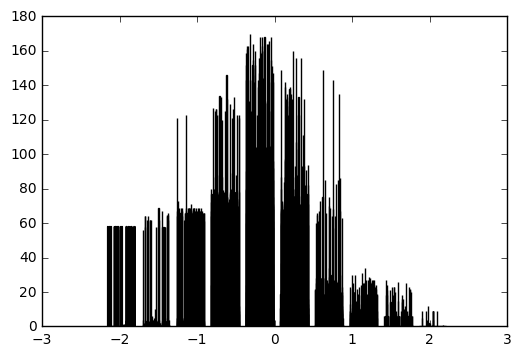

In [42]:
#plt.imshow(np.sqrt(np.square(real_set.get_value()-sampled_vis_layer[0])),interpolation='none')
#plt.axis('tight')
#plt.colorbar()
plt.hist(sampled_vis_layer[0])

([array([   0.,  166.,    0.,    0.,    0.,    4.,    0.,    0.,    0.,    0.]),
  array([   0.,  169.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    1.]),
  array([  36.,  128.,    2.,    1.,    0.,    2.,    1.,    0.,    0.,    0.]),
  array([ 78.,  70.,  20.,   1.,   1.,   0.,   0.,   0.,   0.,   0.]),
  array([ 105.,   44.,   17.,    3.,    0.,    1.,    0.,    0.,    0.,    0.]),
  array([   0.,  157.,    6.,    3.,    4.,    0.,    0.,    0.,    0.,    0.]),
  array([   0.,  165.,    3.,    0.,    0.,    0.,    1.,    1.,    0.,    0.]),
  array([ 76.,  74.,  15.,   3.,   2.,   0.,   0.,   0.,   0.,   0.]),
  array([ 69.,  86.,   9.,   4.,   1.,   1.,   0.,   0.,   0.,   0.]),
  array([ 86.,  66.,  13.,   3.,   1.,   0.,   1.,   0.,   0.,   0.]),
  array([   0.,  158.,    3.,    5.,    3.,    1.,    0.,    0.,    0.,    0.]),
  array([ 78.,  73.,  13.,   5.,   1.,   0.,   0.,   0.,   0.,   0.]),
  array([   0.,  164.,    3.,    2.,    0.,    0.,    0.,    0.,    1.,    0.]

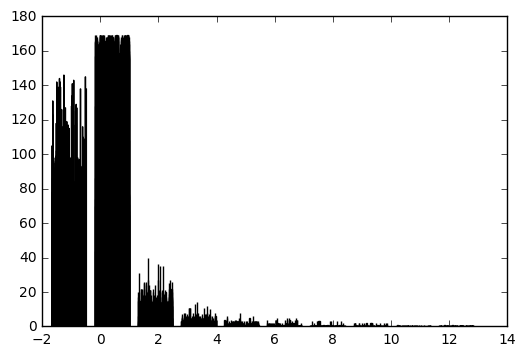

In [43]:
plt.hist(real_set.get_value())

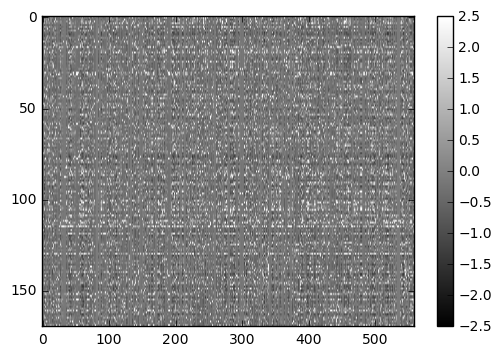

In [44]:
plt.imshow(real_set.get_value(),cmap='gray',clim=(-2.5,2.5))
plt.axis('tight')
plt.colorbar()

In [61]:
c = []
d = []
rss = 0
tss = 0
for i in range(170):
    rss = np.sum(np.square(real_set.get_value()[i]-sampled_vis_layer[0][i])[0])
    tss = np.sum(np.square(real_set.get_value()[i]-np.mean(real_set.get_value()[0]))[0])
    if rss/tss < 1.0:
        c.append(rss/tss)
    else:
        d.append(rss/tss)

(array([ 11.,  56.,   2.,   0.,   1.,   1.,   2.,   2.,   0.,   4.]),
 array([  5.39806888e-06,   9.95620077e-02,   1.99118617e-01,
          2.98675227e-01,   3.98231836e-01,   4.97788446e-01,
          5.97345056e-01,   6.96901665e-01,   7.96458275e-01,
          8.96014884e-01,   9.95571494e-01]),
 <a list of 10 Patch objects>)

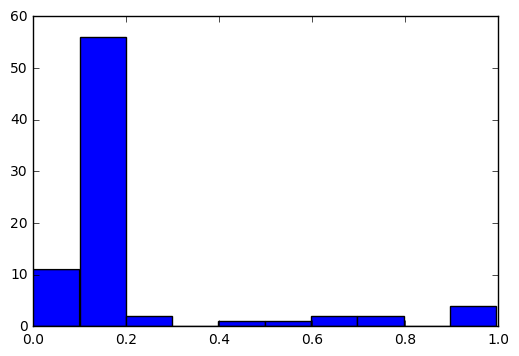

In [59]:
plt.hist(c)

In [60]:
np.mean(c)

0.23270731

In [65]:
len(c)

79

(array([  5.,   3.,  58.,  11.,   0.,   1.,   8.,   3.,   0.,   2.]),
 array([ 1.07753575,  1.47821575,  1.87889576,  2.27957577,  2.68025577,
         3.08093578,  3.48161578,  3.88229579,  4.28297579,  4.6836558 ,
         5.0843358 ]),
 <a list of 10 Patch objects>)

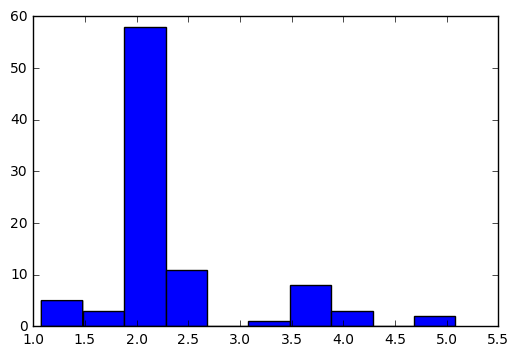

In [62]:
plt.hist(d)

In [63]:
np.mean(d)

2.4030039

In [64]:
len(d)

91